# Installing and importing Dependencies

In [1]:
%pip install yfinance
%pip install pandas_ta
%pip install ta

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import yfinance as yf
from ta.trend import ADXIndicator
import pandas_ta as pd_ta
import random
import torch
import gym
import matplotlib.pyplot as plt
from IPython.display import clear_output
import torch.nn as nn
from torch.distributions import Categorical as Cat
from torch.optim import Adam as adam
# gpu = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
gpu='cpu'

# Environment

## Defining Indicators for the observation

In [3]:
def data_ops(data):
  data.reset_index()
  data.ta.macd(close = 'Close', fast = 12, slow = 26, signal=10, append=True)
  data.ta.rsi(close='Close', length=10, append=True)
  data['TP'] = (data['High'] + data['Low'] + data['Close'])
  data['CCI'] = (data['TP'] - data['TP'].rolling(10).mean()) / (0.015 * data['TP'].rolling(10).std())
  data['Adj Open'] = data.Open * data['Adj Close']/data['Close']
  data['Adj High'] = data.High * data['Adj Close']/data['Close']
  data['Adj Low'] = data.Low * data['Adj Close']/data['Close']
  adxI = ADXIndicator(data['Adj High'], data['Adj Low'], data['Adj Close'], 10, False)
  data['ADX'] = adxI.adx()
  data.dropna()
  req_col = ['Open', 'High', 'Close', 'Low', 'Adj Close', 'MACDs_12_26_10', 'RSI_10', 'CCI', 'ADX']
  new_data = data[req_col]
  return new_data.dropna()

## Defining the environment

In [4]:
class StockTradingEnv:
  def __init__(self, stock = 'DOGE-USD', start = '2022-10-15', end='2022-11-30', period='15m', start_balance=[1000, 1000], step_val = 4):
    data = yf.download(stock, start = start, end = end, interval = period)
    self.data = data_ops(data)
    self.start_bal = start_balance
    self.step_val = step_val
    self.step_bal = [(start_balance[0]/self.data.iloc[0]['Adj Close']), start_balance[1]]
  
  def load_obs(self):
    obs = [None] * 7
    if self.flag0 == 0:
      obs[0] = self.start_bal[1]
      obs[1] = self.start_bal[0]/self.data.iloc[0]['Open']
    else:
      obs[0] = self.step_bal[1]
      obs[1] = self.step_bal[0]/self.data.iloc[self.flag0]['Adj Close']
    obs[2] = self.data.iloc[self.flag0]['Adj Close']
    obs[3] = self.data.iloc[self.flag0]['MACDs_12_26_10']
    obs[4] = self.data.iloc[self.flag0]['RSI_10']
    obs[5] = self.data.iloc[self.flag0]['CCI']
    obs[6] = self.data.iloc[self.flag0]['ADX']
    return obs

  def reset(self):
    self.step_bal = [(self.start_bal[0]/self.data.iloc[0]['Adj Close']), self.start_bal[1]]
    self.flag0 = 0
    self.observation = self.load_obs()
    self.done = False
    self.completed = False
    self.prev_port_val = 2000
    self.port_track = []
    self.prev_port = {}
    return self.observation

  def update_portfolio(self, action):
    val = action * self.data.iloc[self.flag0]['Adj Close']
    reward = 0
    if val > 0:
      if val > self.step_bal[1]:
        reward = -5
      else:
        self.step_bal[0] += action
        self.step_bal[1] -= val
        port_val = self.step_bal[0] * self.data.iloc[self.flag0]['Adj Close'] + self.step_bal[1]
        reward = port_val - self.prev_port_val + 5
        self.prev_port_val = port_val
    elif val < 0 :
      if abs(action) > self.step_bal[0]:
        reward = -10
      else:
        self.step_bal[0] += action
        self.step_bal[1] -= val
        port_val = self.step_bal[0] * self.data.iloc[self.flag0]['Adj Close'] + self.step_bal[1]
        reward = port_val - 2000 + 5
        self.prev_port_val = port_val
    else:
      port_val = self.step_bal[0] * self.data.iloc[self.flag0]['Adj Close'] + self.step_bal[1]
      reward = port_val - 2000 + 10
      self.prev_port_val = port_val
    self.flag0 += 1
    self.observation = self.load_obs()
    return reward     

  def step(self, action):
    action = int(action[0]*100)
    reward = self.update_portfolio(action)
    if self.prev_port_val <= 0:
      self.done = True
    elif self.flag0 == self.data.shape[0]:
      self.completed = True
      self.done = True
    return self.observation, reward, self.completed, self.done

# A2C Implementation

## Defining the A2C architecture

In [5]:
class model(torch.nn.Module):
    def __init__(self,states,actions):
        super(model,self).__init__()
        self.states = states
        self.actions = actions
        
        actor_layers = list()
        actor_layers.append(nn.Linear(self.states,512))
        actor_layers.append(nn.ReLU())
        actor_layers.append(nn.Linear(512,256))
        actor_layers.append(nn.ReLU())
        actor_layers.append(nn.Linear(256,self.actions))
        actor_layers.append(nn.Tanh())
        
        critic_layers = list()
        critic_layers.append(nn.Linear(self.states,512))
        critic_layers.append(nn.ReLU())
        critic_layers.append(nn.Linear(512, 256))
        critic_layers.append(nn.ReLU())
        critic_layers.append(nn.Linear(256,1))

        self.actor_forward = nn.Sequential(*actor_layers)
        self.critic_forward = nn.Sequential(*critic_layers)
        
    def evaluation(self,states,move):
        dist = self.actor_forward(states)
        act_va = torch.full((self.actions,),0.6*0.6).to(gpu).expand_as(dist)
        cov = torch.diag_embed(act_va).to(gpu)
        distri = torch.distributions.MultivariateNormal(dist,cov)
        if self.actions == 1:
            move = move.reshape(-1,self.actions)
        action_probability = distri.log_prob(move)
        entropy = distri.entropy()
        values = self.critic_forward(states)
        return action_probability,values,entropy

    def move(self,states): 
        distri = self.actor_forward(states)
        cov = torch.diag(torch.full((self.actions,),0.6*0.6).to(gpu)).unsqueeze(dim=0)
        dist = torch.distributions.MultivariateNormal(distri,cov)
        actions = dist.sample()
        probability_actions = dist.log_prob(actions)
        return actions.detach(),probability_actions.detach()

## Defining the Training algorithm for A2C

In [6]:
def a2c_training(env, ac_net,
                 optimizer, gamma,
                 episodes, time_limit):
  tot_rew = 0
  rew_per_ep = []
  end_port_value = []
  num_buys = []
  num_sells = []

  def choose_action(state):
    # choosing action using policy network
    action, log_a = ac_net.move(state)
    return action, log_a
  
  def discounted_rewards(rewards, done_inv):
    # Calculating cumulative discounted reward using gamma
    R = 0
    size = len(rewards)
    cd_rewards = [0] * size
    for i in reversed(range(size)):
        R = rewards[i] + gamma * R * done_inv[i]
        cd_rewards[i] = R
    return cd_rewards
  
  def train_step(discounted_rewards, actions, states):
    discounted_rewards = torch.cat(discounted_rewards).detach().to(gpu)
    actions = torch.cat(actions).detach().to(gpu)
    states = torch.squeeze(torch.stack(states, dim=0)).to(gpu)
    acts_prob,values, entropy = ac_net.evaluation(states, actions)
    advantage = discounted_rewards - values
    policy_loss = -(acts_prob * advantage.detach()).mean()
    critic_loss = advantage.pow(2).mean()
    optimizer.zero_grad()
    policy_loss.backward(retain_graph=True)
    critic_loss.backward(retain_graph=True)
    optimizer.step()
    

  for i in range(episodes):
    obs = env.reset()
    done = False
    tot_rew = 0
    rewards = []
    done_invs = []
    actions = []
    states = []
    num_buy = 0
    num_sell = 0
    for t in range(time_limit):
      if done:
        break
      action, log_a = choose_action(torch.FloatTensor(obs))
      if action.numpy()[0] <0:
        num_sell +=1
      else:
        num_buy += 1
      obs_next, r, done, _= env.step(action.numpy()[0])
      states.append(torch.FloatTensor(obs))
      actions.append(action)
      done_inv = 1.0
      if done or (t == (time_limit - 1)):
        done_inv = 0.0
        r = 0
      done_invs.append(torch.tensor([done_inv], dtype=torch.float))
      rewards.append(torch.tensor([r], dtype=torch.float))
      obs = obs_next
      tot_rew+=r
    
    c_dis_rewards = discounted_rewards(rewards, done_invs)
    train_step(c_dis_rewards, actions, states)
    num_buys.append(num_buy)
    num_sells.append(num_sell)
    end_port_value.append(env.prev_port_val)
    rew_per_ep.append(tot_rew)
    if i % (episodes/100) == 0 and i!=0:
      clear_output(wait=True)
      print("percent complete:",int((i/episodes)*100),"| score:",tot_rew, "| Port val:",env.prev_port_val)
    
  clear_output(wait=True)
  print("Training completed, last episode score:",tot_rew)
  return ac_net, rew_per_ep, end_port_value, num_buys, num_sells

## Training the environment on A2C

In [7]:
learning_rate = 0.001
env = StockTradingEnv()
ac_net = model(7,1)
episode_limit = 4000
episodes = 1000
gamma = 0.99
optimizer = adam(ac_net.parameters(), lr=learning_rate)
net, rew_p_e, end_port_vals, num_buys, num_sells = a2c_training(env, ac_net, optimizer, gamma, episodes,episode_limit)

Training completed, last episode score: 160449.34780663185


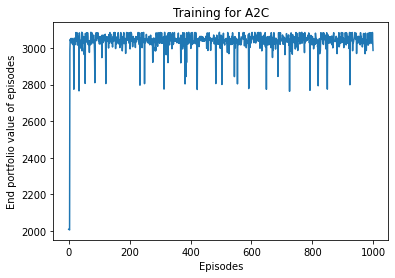

In [8]:
plt.plot(end_port_vals)
plt.title("Training for A2C")
plt.xlabel("Episodes")
plt.ylabel("End portfolio value of episodes")
plt.show()

## Testing the environment on A2C

In [12]:
env = StockTradingEnv()
obs = env.reset()
done = False
rews = []
end_port_vals_test = []
for i in range(10):
  done = False
  obs = env.reset()
  tot_rew = 0
  for i in range(4000):
    action, log_a = net.move(torch.FloatTensor(obs))
    obs, r, done, _= env.step(action.numpy()[0])
    tot_rew += r
  rews.append(tot_rew)
  end_port_vals_test.append(env.prev_port_val)

[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.8/dist-packages/ta/trend.py:780: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
/usr/local/lib/python3.8/dist-packages/ta/trend.py:785: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)


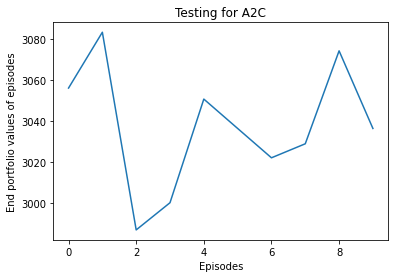

In [13]:
plt.plot(end_port_vals_test)
plt.title("Testing for A2C")
plt.xlabel("Episodes")
plt.ylabel("End portfolio values of episodes")
plt.show()

In [14]:
np.mean(end_port_vals_test)

3037.5357370164065